## IMPORT MODULES

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
%matplotlib inline

# about %matplotlib inline
# https://stackoverflow.com/questions/43027980/purpose-of-matplotlib-inline/43028034
# https://stackoverflow.com/questions/19410042/how-to-make-ipython-notebook-matplotlib-plot-inline

## DATA

In [17]:
data = pd.read_csv("data/winequality-red.csv")
data.shape

(1599, 12)

In [18]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [19]:
data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [20]:
data.shape

(1599, 12)

# V.1: Exploring the green reds

## a) Write a function that will plot a scatterplot matrix of your red wine data.

In [21]:
def plot_scatter_matrix(data, good_threshold, bad_threshold, save_plot=False, quality=True):
    
    names = data.columns
    good_data = data.loc[data['quality'] >= good_threshold]
    bad_data = data.loc[data['quality'] <= bad_threshold]

    if quality==False:
        good_data = good_data.drop('quality', 1)
        bad_data = bad_data.drop('quality', 1)
        names = good_data.columns

    
    numvars, numdata = good_data.shape
    fig, axes = plt.subplots(nrows=numdata, ncols=numdata, figsize=(20,20))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    
    for ax in axes.flat:
        # Hide all ticks and labels
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

    # Plot the data.
    for i in range(0, numdata):
        for j in range(0, numdata):
            if (i != j):
                for x, y in [(i,j), (j,i)]:
                    #iloc allows me to grab by index so when I'm plotting it just uses the column index and plots them.
                    axes[x,y].plot(bad_data.iloc[:, y], bad_data.iloc[:, x], linestyle='none', marker='.', color='red', mfc='none')
                    axes[x,y].plot(good_data.iloc[:, y], good_data.iloc[:, x], linestyle='none', marker='.', color='green', mfc='none')

    # Label the diagonal subplots...
    for i, label in enumerate(names):
        axes[i,i].annotate(label, (0.5, 0.5), xycoords='axes fraction',
                ha='center', va='center')
    if (save_plot == True):
        plt.savefig('scatter_plot.png')
    return fig


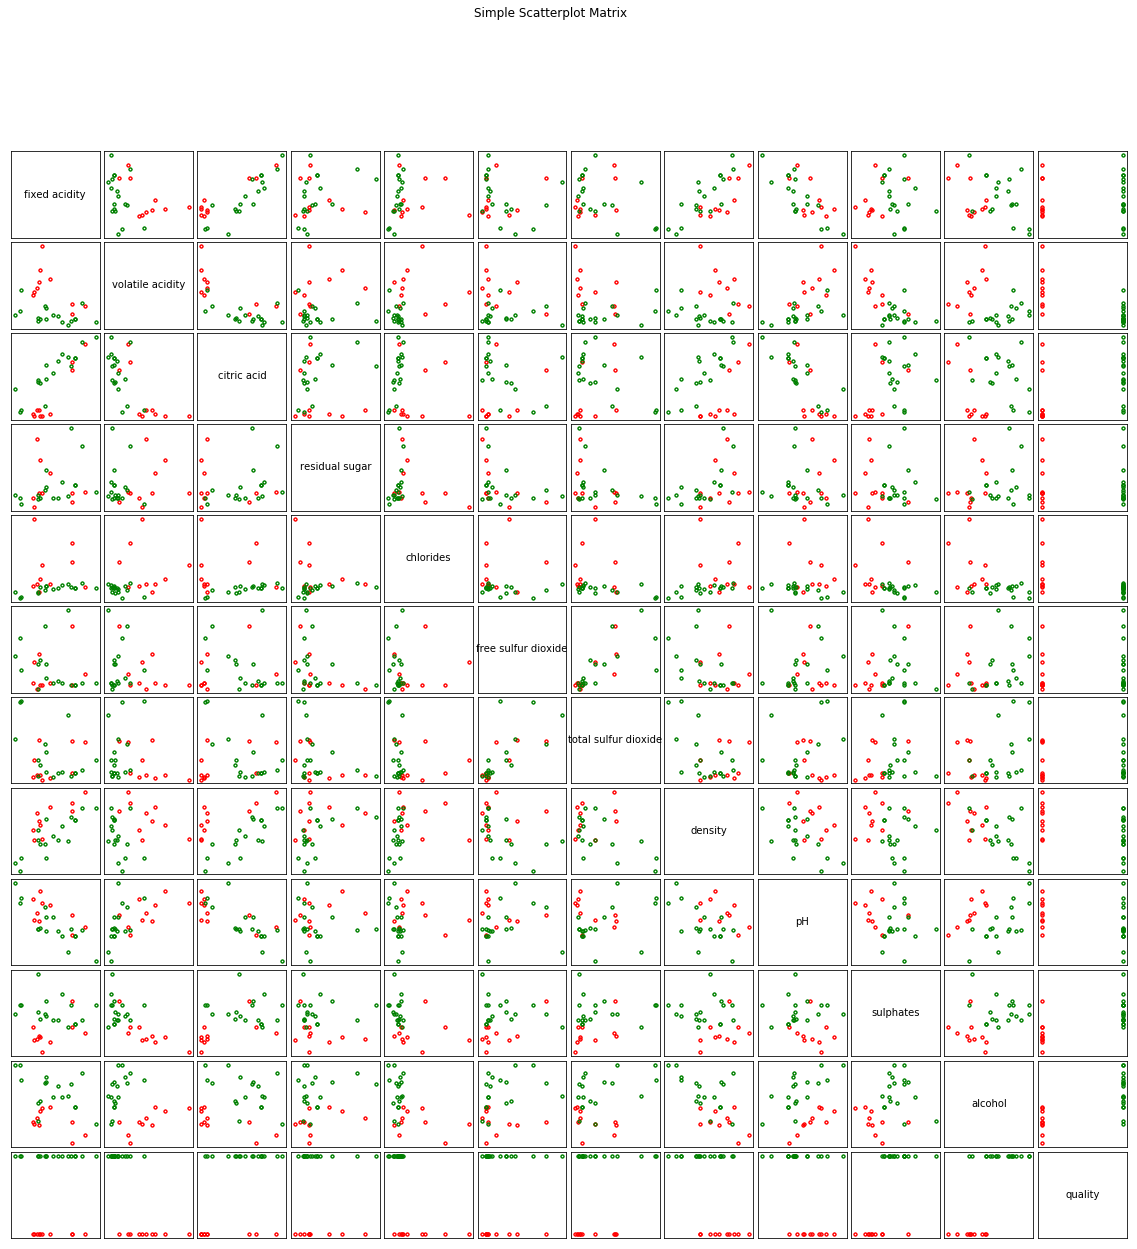

In [9]:
good_threshold = 8
bad_threshold = 3

fig = plot_scatter_matrix(data,good_threshold,bad_threshold,save_plot=False)
fig.suptitle('Simple Scatterplot Matrix')
plt.show()

## b) Which factors do you think will be most useful to your perceptron for distinguishing high quality vs. low quality wines? Why?

### 1-Dimensional Analysis    
    1) Lower volatile acidity trended to higher quality
    2) Low chlorides led trended to higher quality
    3) Higher alcohol content trended to higher quality
    4) Higher sulphates trended to higher quality
    5) Lower density trended to higher quality
    6) Lower pH trended to higher quality
    7) Most low quality wines had low citric acid
    8) Lower Sulfer dioxide trended to lower quality
 
### 2-Dimensional Analysis
    * plots with greater separation between green and red show that these two factors have a relationship to quality 
    * poolings of green or red are also good indicators to relationship of quality
    
    1) Higher alcohol content with low volatile acidity led to higher ratings
    2) Lower Density and higher citric acid showed a trended to higher ratings
    3) High citric acid and low chlorides showed higher ratings
    
#### I think that volatile acidity, chlorids, sulphates, and alcohol content will be the most useful factors in deciding quality of wine because of the severity of their grouping and large disparity between high and low wines.
    

# V.2 Learning to Perceptron

## a) Implement a perceptron that:
   
       * Has randomly initialized weights and bias
       * Uses the Rosenblatt perceptron learning rule (with changeable learning rate)
       * Utilizes the heaviside step activation function (discrete version)

## Equations for Prediction

### Formula for activation function:
    * activation = (weight(0) * X(0)) + (weight(n) * x(n)) + bias

### Heaviside step activation function:
    * if activation is > 0 then it predicts 1 if else returns 0.
    * simple binary classification

In [1]:
def predict(row, weights):
    activation = weights[0]
    for i in range(len(row)-1):
        #iterate through inputs and multiply them to corresponding weights
        activation += weights[i + 1] * row[i]
        
    #use a transfer function to change value to 1 or 0.
    return 1.0 if activation >= 0.0 else 0.0

## b) Implement a function to train your perceptron

    • Have a way to specify number of training epochs
    • Train your perceptron until it makes no errors, if training epochs is set to 0,
    • Have a way to specify learning rate.
    • Return a list of python tuples containing (performance)

# Training

## There are 3 loops we need to perform in the function:

    1) Loop over each epoch.
    2) Loop over each row in the training data per epoch.
    3) Loop over each weight per feature in row.
    4) Calculate the prediction with the respective weights to input
    5) Recalculate the weights using this function:
            New Weight = Old Weight + (l_rate * (x) * error)

In [14]:
# Estimate Perceptron weights using stochastic gradient descent

#The perceptron learning rule basically just adds the actual value 
def train_perceptron(train, l_rate, n_epoch):
    performance = []

    #random weights
    random.seed(1)
    weights = [random.uniform(0, 1) for i in range(len(train[0]))]
    
    #for each epoch
    for epoch in range(n_epoch):
        sum_error = 0.0
        #for each row
        for row in train:
            prediction = predict(row, weights)
            error = row[-1] - prediction
            sum_error += abs(error)
            weights[0] = weights[0] + l_rate * error
            #for each weight
            for i in range(len(row) - 1):
                weights[i + 1] = weights[i + 1] + (l_rate * row[i] * error)
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
        performance.append((epoch, sum_error, weights[1:], weights[0]))
    if n_epoch <= 0:
        epoch = 0
        sum_error = 1.0
        while sum_error != 0:
            sum_error = 0.0
            for row in train:
                prediction = predict(row, weights)
                error = row[-1] - prediction
                sum_error += abs(error)
                weights[0] = weights[0] + l_rate * error
                for i in range(len(row) - 1):
                    weights[i + 1] = weights[i + 1] + (l_rate * row[i] * error)
            print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))            
            performance.append((epoch, sum_error, weights[1:], weights[0]))
            epoch += 1 
    print(weights)
    return performance

In [15]:
def dataframe_to_list(data):
        #convert to list
        return data.values.tolist()

In [16]:
def parse_dataframe(data, good_threshold, bad_threshold, columns, set_range=False):
    new_data = data.copy()

    if (set_range==False):
        #Covert all labels to 1 or 0 with threshold of good and bad
        new_data['good_bad'] = [1 if x >= good_threshold else 0 for x in new_data['quality']]
    else:
        #Covert all labels to 1 or -1 with threshold of good and bad
        new_data['good_bad'] = [1 if x >= good_threshold else -1 for x in new_data['quality']]
    
    #Grab all data higher than 8 or lower than 3 in quality.
    new_data = new_data.loc[(data['quality'] >= good_threshold) | (data['quality'] <= bad_threshold)]
    
    #Grab only the specified columns
    new_data = new_data.loc[:, columns]
    
    new_data = new_data.reset_index(drop=True)
    return(new_data)


In [17]:
test_train = parse_dataframe(data, good_threshold=8, bad_threshold=3, columns=['pH', 'alcohol', 'good_bad'])
test_train = dataframe_to_list(test_train)
test_train

[[3.35, 12.8, 1.0],
 [3.23, 12.6, 1.0],
 [3.56, 12.9, 1.0],
 [2.88, 9.8, 1.0],
 [3.22, 13.4, 1.0],
 [3.25, 9.0, 0.0],
 [3.15, 11.7, 1.0],
 [3.15, 11.0, 1.0],
 [3.15, 11.0, 1.0],
 [3.16, 8.4, 0.0],
 [3.72, 14.0, 1.0],
 [3.63, 10.7, 0.0],
 [3.46, 12.7, 1.0],
 [3.38, 9.9, 0.0],
 [3.48, 11.0, 0.0],
 [3.21, 12.5, 1.0],
 [2.98, 11.8, 1.0],
 [3.2, 13.1, 1.0],
 [3.35, 11.7, 1.0],
 [3.5, 14.0, 1.0],
 [3.5, 10.9, 0.0],
 [3.32, 9.8, 0.0],
 [3.23, 10.0, 1.0],
 [3.23, 11.3, 1.0],
 [3.31, 9.7, 0.0],
 [3.4, 10.2, 0.0],
 [3.55, 9.95, 0.0],
 [3.24, 11.4, 1.0]]

In [18]:
performance = train_perceptron(test_train, l_rate=5, n_epoch=0)

>epoch=0, lrate=5.000, error=13.000
>epoch=1, lrate=5.000, error=13.000
>epoch=2, lrate=5.000, error=11.000
>epoch=3, lrate=5.000, error=11.000
>epoch=4, lrate=5.000, error=11.000
>epoch=5, lrate=5.000, error=13.000
>epoch=6, lrate=5.000, error=11.000
>epoch=7, lrate=5.000, error=9.000
>epoch=8, lrate=5.000, error=4.000
>epoch=9, lrate=5.000, error=6.000
>epoch=10, lrate=5.000, error=7.000
>epoch=11, lrate=5.000, error=6.000
>epoch=12, lrate=5.000, error=6.000
>epoch=13, lrate=5.000, error=9.000
>epoch=14, lrate=5.000, error=2.000
>epoch=15, lrate=5.000, error=2.000
>epoch=16, lrate=5.000, error=4.000
>epoch=17, lrate=5.000, error=6.000
>epoch=18, lrate=5.000, error=9.000
>epoch=19, lrate=5.000, error=2.000
>epoch=20, lrate=5.000, error=2.000
>epoch=21, lrate=5.000, error=4.000
>epoch=22, lrate=5.000, error=6.000
>epoch=23, lrate=5.000, error=8.000
>epoch=24, lrate=5.000, error=9.000
>epoch=25, lrate=5.000, error=8.000
>epoch=26, lrate=5.000, error=7.000
>epoch=27, lrate=5.000, error=6

>epoch=1377, lrate=5.000, error=2.000
>epoch=1378, lrate=5.000, error=2.000
>epoch=1379, lrate=5.000, error=2.000
>epoch=1380, lrate=5.000, error=1.000
>epoch=1381, lrate=5.000, error=2.000
>epoch=1382, lrate=5.000, error=2.000
>epoch=1383, lrate=5.000, error=2.000
>epoch=1384, lrate=5.000, error=2.000
>epoch=1385, lrate=5.000, error=2.000
>epoch=1386, lrate=5.000, error=2.000
>epoch=1387, lrate=5.000, error=2.000
>epoch=1388, lrate=5.000, error=2.000
>epoch=1389, lrate=5.000, error=2.000
>epoch=1390, lrate=5.000, error=2.000
>epoch=1391, lrate=5.000, error=2.000
>epoch=1392, lrate=5.000, error=2.000
>epoch=1393, lrate=5.000, error=2.000
>epoch=1394, lrate=5.000, error=2.000
>epoch=1395, lrate=5.000, error=2.000
>epoch=1396, lrate=5.000, error=2.000
>epoch=1397, lrate=5.000, error=2.000
>epoch=1398, lrate=5.000, error=2.000
>epoch=1399, lrate=5.000, error=2.000
>epoch=1400, lrate=5.000, error=2.000
>epoch=1401, lrate=5.000, error=2.000
>epoch=1402, lrate=5.000, error=2.000
>epoch=1403,

>epoch=2377, lrate=5.000, error=2.000
>epoch=2378, lrate=5.000, error=2.000
>epoch=2379, lrate=5.000, error=2.000
>epoch=2380, lrate=5.000, error=2.000
>epoch=2381, lrate=5.000, error=2.000
>epoch=2382, lrate=5.000, error=2.000
>epoch=2383, lrate=5.000, error=2.000
>epoch=2384, lrate=5.000, error=2.000
>epoch=2385, lrate=5.000, error=2.000
>epoch=2386, lrate=5.000, error=2.000
>epoch=2387, lrate=5.000, error=1.000
>epoch=2388, lrate=5.000, error=2.000
>epoch=2389, lrate=5.000, error=2.000
>epoch=2390, lrate=5.000, error=2.000
>epoch=2391, lrate=5.000, error=2.000
>epoch=2392, lrate=5.000, error=2.000
>epoch=2393, lrate=5.000, error=2.000
>epoch=2394, lrate=5.000, error=2.000
>epoch=2395, lrate=5.000, error=2.000
>epoch=2396, lrate=5.000, error=2.000
>epoch=2397, lrate=5.000, error=2.000
>epoch=2398, lrate=5.000, error=2.000
>epoch=2399, lrate=5.000, error=2.000
>epoch=2400, lrate=5.000, error=2.000
>epoch=2401, lrate=5.000, error=2.000
>epoch=2402, lrate=5.000, error=2.000
>epoch=2403,

>epoch=3376, lrate=5.000, error=2.000
>epoch=3377, lrate=5.000, error=2.000
>epoch=3378, lrate=5.000, error=2.000
>epoch=3379, lrate=5.000, error=2.000
>epoch=3380, lrate=5.000, error=2.000
>epoch=3381, lrate=5.000, error=2.000
>epoch=3382, lrate=5.000, error=2.000
>epoch=3383, lrate=5.000, error=2.000
>epoch=3384, lrate=5.000, error=2.000
>epoch=3385, lrate=5.000, error=2.000
>epoch=3386, lrate=5.000, error=2.000
>epoch=3387, lrate=5.000, error=2.000
>epoch=3388, lrate=5.000, error=2.000
>epoch=3389, lrate=5.000, error=2.000
>epoch=3390, lrate=5.000, error=2.000
>epoch=3391, lrate=5.000, error=1.000
>epoch=3392, lrate=5.000, error=2.000
>epoch=3393, lrate=5.000, error=2.000
>epoch=3394, lrate=5.000, error=2.000
>epoch=3395, lrate=5.000, error=2.000
>epoch=3396, lrate=5.000, error=2.000
>epoch=3397, lrate=5.000, error=2.000
>epoch=3398, lrate=5.000, error=2.000
>epoch=3399, lrate=5.000, error=2.000
>epoch=3400, lrate=5.000, error=2.000
>epoch=3401, lrate=5.000, error=2.000
>epoch=3402,

>epoch=4376, lrate=5.000, error=2.000
>epoch=4377, lrate=5.000, error=2.000
>epoch=4378, lrate=5.000, error=2.000
>epoch=4379, lrate=5.000, error=2.000
>epoch=4380, lrate=5.000, error=2.000
>epoch=4381, lrate=5.000, error=2.000
>epoch=4382, lrate=5.000, error=2.000
>epoch=4383, lrate=5.000, error=2.000
>epoch=4384, lrate=5.000, error=2.000
>epoch=4385, lrate=5.000, error=2.000
>epoch=4386, lrate=5.000, error=1.000
>epoch=4387, lrate=5.000, error=2.000
>epoch=4388, lrate=5.000, error=2.000
>epoch=4389, lrate=5.000, error=2.000
>epoch=4390, lrate=5.000, error=2.000
>epoch=4391, lrate=5.000, error=2.000
>epoch=4392, lrate=5.000, error=2.000
>epoch=4393, lrate=5.000, error=2.000
>epoch=4394, lrate=5.000, error=2.000
>epoch=4395, lrate=5.000, error=2.000
>epoch=4396, lrate=5.000, error=2.000
>epoch=4397, lrate=5.000, error=2.000
>epoch=4398, lrate=5.000, error=2.000
>epoch=4399, lrate=5.000, error=2.000
>epoch=4400, lrate=5.000, error=2.000
>epoch=4401, lrate=5.000, error=2.000
>epoch=4402,

>epoch=5375, lrate=5.000, error=2.000
>epoch=5376, lrate=5.000, error=2.000
>epoch=5377, lrate=5.000, error=2.000
>epoch=5378, lrate=5.000, error=2.000
>epoch=5379, lrate=5.000, error=2.000
>epoch=5380, lrate=5.000, error=2.000
>epoch=5381, lrate=5.000, error=1.000
>epoch=5382, lrate=5.000, error=2.000
>epoch=5383, lrate=5.000, error=2.000
>epoch=5384, lrate=5.000, error=2.000
>epoch=5385, lrate=5.000, error=2.000
>epoch=5386, lrate=5.000, error=2.000
>epoch=5387, lrate=5.000, error=2.000
>epoch=5388, lrate=5.000, error=2.000
>epoch=5389, lrate=5.000, error=2.000
>epoch=5390, lrate=5.000, error=2.000
>epoch=5391, lrate=5.000, error=2.000
>epoch=5392, lrate=5.000, error=2.000
>epoch=5393, lrate=5.000, error=2.000
>epoch=5394, lrate=5.000, error=2.000
>epoch=5395, lrate=5.000, error=2.000
>epoch=5396, lrate=5.000, error=2.000
>epoch=5397, lrate=5.000, error=2.000
>epoch=5398, lrate=5.000, error=2.000
>epoch=5399, lrate=5.000, error=2.000
>epoch=5400, lrate=5.000, error=1.000
>epoch=5401,

>epoch=6375, lrate=5.000, error=2.000
>epoch=6376, lrate=5.000, error=1.000
>epoch=6377, lrate=5.000, error=2.000
>epoch=6378, lrate=5.000, error=2.000
>epoch=6379, lrate=5.000, error=2.000
>epoch=6380, lrate=5.000, error=2.000
>epoch=6381, lrate=5.000, error=2.000
>epoch=6382, lrate=5.000, error=2.000
>epoch=6383, lrate=5.000, error=2.000
>epoch=6384, lrate=5.000, error=2.000
>epoch=6385, lrate=5.000, error=2.000
>epoch=6386, lrate=5.000, error=2.000
>epoch=6387, lrate=5.000, error=2.000
>epoch=6388, lrate=5.000, error=2.000
>epoch=6389, lrate=5.000, error=2.000
>epoch=6390, lrate=5.000, error=2.000
>epoch=6391, lrate=5.000, error=2.000
>epoch=6392, lrate=5.000, error=2.000
>epoch=6393, lrate=5.000, error=2.000
>epoch=6394, lrate=5.000, error=1.000
>epoch=6395, lrate=5.000, error=2.000
>epoch=6396, lrate=5.000, error=2.000
>epoch=6397, lrate=5.000, error=2.000
>epoch=6398, lrate=5.000, error=2.000
>epoch=6399, lrate=5.000, error=2.000
>epoch=6400, lrate=5.000, error=2.000
>epoch=6401,

>epoch=7374, lrate=5.000, error=2.000
>epoch=7375, lrate=5.000, error=2.000
>epoch=7376, lrate=5.000, error=2.000
>epoch=7377, lrate=5.000, error=2.000
>epoch=7378, lrate=5.000, error=2.000
>epoch=7379, lrate=5.000, error=2.000
>epoch=7380, lrate=5.000, error=2.000
>epoch=7381, lrate=5.000, error=2.000
>epoch=7382, lrate=5.000, error=2.000
>epoch=7383, lrate=5.000, error=2.000
>epoch=7384, lrate=5.000, error=2.000
>epoch=7385, lrate=5.000, error=2.000
>epoch=7386, lrate=5.000, error=2.000
>epoch=7387, lrate=5.000, error=2.000
>epoch=7388, lrate=5.000, error=2.000
>epoch=7389, lrate=5.000, error=1.000
>epoch=7390, lrate=5.000, error=2.000
>epoch=7391, lrate=5.000, error=2.000
>epoch=7392, lrate=5.000, error=2.000
>epoch=7393, lrate=5.000, error=2.000
>epoch=7394, lrate=5.000, error=2.000
>epoch=7395, lrate=5.000, error=2.000
>epoch=7396, lrate=5.000, error=2.000
>epoch=7397, lrate=5.000, error=2.000
>epoch=7398, lrate=5.000, error=2.000
>epoch=7399, lrate=5.000, error=2.000
>epoch=7400,

>epoch=8374, lrate=5.000, error=2.000
>epoch=8375, lrate=5.000, error=2.000
>epoch=8376, lrate=5.000, error=2.000
>epoch=8377, lrate=5.000, error=2.000
>epoch=8378, lrate=5.000, error=2.000
>epoch=8379, lrate=5.000, error=2.000
>epoch=8380, lrate=5.000, error=2.000
>epoch=8381, lrate=5.000, error=2.000
>epoch=8382, lrate=5.000, error=2.000
>epoch=8383, lrate=5.000, error=2.000
>epoch=8384, lrate=5.000, error=1.000
>epoch=8385, lrate=5.000, error=2.000
>epoch=8386, lrate=5.000, error=2.000
>epoch=8387, lrate=5.000, error=2.000
>epoch=8388, lrate=5.000, error=2.000
>epoch=8389, lrate=5.000, error=2.000
>epoch=8390, lrate=5.000, error=2.000
>epoch=8391, lrate=5.000, error=2.000
>epoch=8392, lrate=5.000, error=2.000
>epoch=8393, lrate=5.000, error=2.000
>epoch=8394, lrate=5.000, error=2.000
>epoch=8395, lrate=5.000, error=2.000
>epoch=8396, lrate=5.000, error=2.000
>epoch=8397, lrate=5.000, error=2.000
>epoch=8398, lrate=5.000, error=2.000
>epoch=8399, lrate=5.000, error=2.000
>epoch=8400,

>epoch=9373, lrate=5.000, error=2.000
>epoch=9374, lrate=5.000, error=2.000
>epoch=9375, lrate=5.000, error=2.000
>epoch=9376, lrate=5.000, error=2.000
>epoch=9377, lrate=5.000, error=2.000
>epoch=9378, lrate=5.000, error=2.000
>epoch=9379, lrate=5.000, error=1.000
>epoch=9380, lrate=5.000, error=2.000
>epoch=9381, lrate=5.000, error=2.000
>epoch=9382, lrate=5.000, error=2.000
>epoch=9383, lrate=5.000, error=2.000
>epoch=9384, lrate=5.000, error=2.000
>epoch=9385, lrate=5.000, error=2.000
>epoch=9386, lrate=5.000, error=2.000
>epoch=9387, lrate=5.000, error=2.000
>epoch=9388, lrate=5.000, error=2.000
>epoch=9389, lrate=5.000, error=2.000
>epoch=9390, lrate=5.000, error=2.000
>epoch=9391, lrate=5.000, error=2.000
>epoch=9392, lrate=5.000, error=2.000
>epoch=9393, lrate=5.000, error=2.000
>epoch=9394, lrate=5.000, error=2.000
>epoch=9395, lrate=5.000, error=2.000
>epoch=9396, lrate=5.000, error=2.000
>epoch=9397, lrate=5.000, error=2.000
>epoch=9398, lrate=5.000, error=1.000
>epoch=9399,

>epoch=10373, lrate=5.000, error=2.000
>epoch=10374, lrate=5.000, error=1.000
>epoch=10375, lrate=5.000, error=2.000
>epoch=10376, lrate=5.000, error=2.000
>epoch=10377, lrate=5.000, error=2.000
>epoch=10378, lrate=5.000, error=2.000
>epoch=10379, lrate=5.000, error=2.000
>epoch=10380, lrate=5.000, error=2.000
>epoch=10381, lrate=5.000, error=2.000
>epoch=10382, lrate=5.000, error=2.000
>epoch=10383, lrate=5.000, error=2.000
>epoch=10384, lrate=5.000, error=2.000
>epoch=10385, lrate=5.000, error=2.000
>epoch=10386, lrate=5.000, error=2.000
>epoch=10387, lrate=5.000, error=2.000
>epoch=10388, lrate=5.000, error=2.000
>epoch=10389, lrate=5.000, error=2.000
>epoch=10390, lrate=5.000, error=2.000
>epoch=10391, lrate=5.000, error=2.000
>epoch=10392, lrate=5.000, error=2.000
>epoch=10393, lrate=5.000, error=1.000
>epoch=10394, lrate=5.000, error=2.000
>epoch=10395, lrate=5.000, error=2.000
>epoch=10396, lrate=5.000, error=2.000
>epoch=10397, lrate=5.000, error=2.000
>epoch=10398, lrate=5.000

>epoch=11372, lrate=5.000, error=2.000
>epoch=11373, lrate=5.000, error=2.000
>epoch=11374, lrate=5.000, error=2.000
>epoch=11375, lrate=5.000, error=2.000
>epoch=11376, lrate=5.000, error=2.000
>epoch=11377, lrate=5.000, error=2.000
>epoch=11378, lrate=5.000, error=2.000
>epoch=11379, lrate=5.000, error=2.000
>epoch=11380, lrate=5.000, error=2.000
>epoch=11381, lrate=5.000, error=2.000
>epoch=11382, lrate=5.000, error=2.000
>epoch=11383, lrate=5.000, error=2.000
>epoch=11384, lrate=5.000, error=2.000
>epoch=11385, lrate=5.000, error=2.000
>epoch=11386, lrate=5.000, error=2.000
>epoch=11387, lrate=5.000, error=2.000
>epoch=11388, lrate=5.000, error=1.000
>epoch=11389, lrate=5.000, error=2.000
>epoch=11390, lrate=5.000, error=2.000
>epoch=11391, lrate=5.000, error=2.000
>epoch=11392, lrate=5.000, error=2.000
>epoch=11393, lrate=5.000, error=2.000
>epoch=11394, lrate=5.000, error=2.000
>epoch=11395, lrate=5.000, error=2.000
>epoch=11396, lrate=5.000, error=2.000
>epoch=11397, lrate=5.000

>epoch=12372, lrate=5.000, error=2.000
>epoch=12373, lrate=5.000, error=2.000
>epoch=12374, lrate=5.000, error=2.000
>epoch=12375, lrate=5.000, error=2.000
>epoch=12376, lrate=5.000, error=2.000
>epoch=12377, lrate=5.000, error=2.000
>epoch=12378, lrate=5.000, error=2.000
>epoch=12379, lrate=5.000, error=2.000
>epoch=12380, lrate=5.000, error=2.000
>epoch=12381, lrate=5.000, error=2.000
>epoch=12382, lrate=5.000, error=2.000
>epoch=12383, lrate=5.000, error=1.000
>epoch=12384, lrate=5.000, error=2.000
>epoch=12385, lrate=5.000, error=2.000
>epoch=12386, lrate=5.000, error=2.000
>epoch=12387, lrate=5.000, error=2.000
>epoch=12388, lrate=5.000, error=2.000
>epoch=12389, lrate=5.000, error=2.000
>epoch=12390, lrate=5.000, error=2.000
>epoch=12391, lrate=5.000, error=2.000
>epoch=12392, lrate=5.000, error=2.000
>epoch=12393, lrate=5.000, error=2.000
>epoch=12394, lrate=5.000, error=2.000
>epoch=12395, lrate=5.000, error=2.000
>epoch=12396, lrate=5.000, error=2.000
>epoch=12397, lrate=5.000

In [19]:
# for row in test_train:
#     prediction = predict(row, weights)
#     print("Expected=%d, Predicted=%d" % (row[-1], prediction))

In [20]:
#Format (epoch, error, weights, bias)
print(performance[0])

(0, 13.0, [-16.852566263062755, 20.263774618976612], -4.865635755887599)


## c) Plotting performance
    
    • The first plot should plot the number of errors your perceptron made as a function of epoch. Be careful with how you calculate errors!
    • The second plot should plot the decision boundary of your perceptron and also show ‘good’ and ‘bad’ wine data points on the final training epoch. This second plot should also shade ‘good’ and ‘bad’ areas!
    • Your function should allow the user to specify a specific epoch and see what the decision boundary of the perceptron was on that epoch. If a negative epoch is given, cause the plots to show the last epoch.

In [10]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

def eval_y_per_x(formula, x_values):
    y_values = []
    for x in x_values:
        y_values.append(eval(formula))
    return y_values

def graph(formula, wine_data, ax2):     
    x = wine_data.alcohol.tolist()
    x = [i for i in frange(min(x), max(x), .1)]
    y = eval_y_per_x(formula, x)
    d_min = [min(y) for l in range(0, len(x))]
    d_max = max(y)
    ax2.plot(x, y, linestyle='dashed', label='decision boundary')
    ax2.fill_between(x, y, d_min, facecolor='lightgreen', alpha=0.5)
    ax2.fill_between(x, y, d_max, facecolor='pink', alpha=0.5)

In [22]:
#if epoch is equal to -1 then it shows the line for last epoch
#please put a valid epoch under the number of epoch's attempted

def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch, save_plot=False):
    #Separate Data to good and bad wine depending on threshold
    good_data = wine_data.loc[data['quality'] >= good_thresh]
    bad_data = wine_data.loc[data['quality'] <= bad_thresh]
   
    listofepochs = [x[0] for x in performance]
    error = [x[1] for x in performance]
    
    #find length of epoch's so I can use last one if -1
    if (epoch >= len(listofepochs)):
        print("Please Put Valid Epoch. If you wish for last epoch put -1")
        return
    
    if (epoch < 0):
        epoch = len(listofepochs) - 1
        
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2)
    ax1.plot(listofepochs, error)
    ax1.set_title('Error / Epoch Graph')
    ax1.set_ylabel('Sum_Error')
    ax1.set_xlabel('Epoch #')

    ax2.scatter(good_data.alcohol.tolist(), good_data.pH.tolist(), color = 'green', label='good')
    ax2.scatter(bad_data.alcohol.tolist(), bad_data.pH.tolist(), color = 'red', label='bad')
    formula = '({}*x + {})/-{}'.format(performance[epoch][2][1], performance[epoch][3], performance[epoch][2][0])

    graph(formula, wine_data, ax2)
    ax2.set_title('Decision boundary on epoch: {}'.format(epoch))
    ax2.set_ylabel('pH')
    ax2.set_xlabel('alcohol')
    ax2.legend()
    if (save_plot == True):
        plt.savefig('batchsize_35_graph.png')

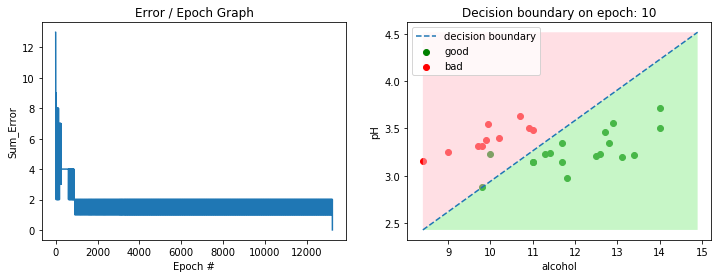

In [23]:
plot_performance(performance, data, good_thresh=8, bad_thresh=3, epoch=10, save_plot=False)

## d) Feature Scailing

The reason it takes so many epochs to train is because the data is not normalized (or represented between 0 and 1). It takes alot longer for the bias and weights to calibrate for numbers that are larger than one. 


## Normalization

Function for normalizing is ((X - min) / (max - min))    

In [24]:
norm_data = data.copy()
features = [x for x in norm_data.columns]
for feature in features:
    maxim = norm_data[feature].max()
    minim = norm_data[feature].min()
    print(feature, maxim, minim)
    if feature != 'quality':
        norm_data[feature] = norm_data[feature].apply(lambda x: (x - minim) / (maxim - minim))
    
# #Double Check if it was normalized
# norm_data.describe()

fixed acidity 15.9 4.6
volatile acidity 1.58 0.12
citric acid 1.0 0.0
residual sugar 15.5 0.9
chlorides 0.611 0.012
free sulfur dioxide 72.0 1.0
total sulfur dioxide 289.0 6.0
density 1.00369 0.99007
pH 4.01 2.74
sulphates 2.0 0.33
alcohol 14.9 8.4
quality 8 3


In [25]:
norm_train1 = parse_dataframe(norm_data, 8, 3, ['pH', 'alcohol', 'good_bad'])
norm_train1 = dataframe_to_list(norm_train1)

In [26]:
norm_train1

[[0.48031496062992135, 0.676923076923077, 1.0],
 [0.38582677165354323, 0.6461538461538461, 1.0],
 [0.6456692913385828, 0.6923076923076923, 1.0],
 [0.11023622047244074, 0.21538461538461545, 1.0],
 [0.3779527559055119, 0.7692307692307693, 1.0],
 [0.40157480314960625, 0.09230769230769226, 0.0],
 [0.3228346456692912, 0.5076923076923076, 1.0],
 [0.3228346456692912, 0.39999999999999997, 1.0],
 [0.3228346456692912, 0.39999999999999997, 1.0],
 [0.3307086614173229, 0.0, 0.0],
 [0.7716535433070869, 0.8615384615384615, 1.0],
 [0.7007874015748031, 0.3538461538461537, 0.0],
 [0.5669291338582677, 0.6615384615384614, 1.0],
 [0.5039370078740156, 0.23076923076923078, 0.0],
 [0.5826771653543307, 0.39999999999999997, 0.0],
 [0.37007874015748027, 0.6307692307692307, 1.0],
 [0.1889763779527558, 0.5230769230769231, 1.0],
 [0.3622047244094489, 0.723076923076923, 1.0],
 [0.48031496062992135, 0.5076923076923076, 1.0],
 [0.5984251968503937, 0.8615384615384615, 1.0],
 [0.5984251968503937, 0.38461538461538464, 0.

In [27]:
l_rate = 5
n_epoch = 0
performance = train_perceptron(norm_train1, l_rate, n_epoch)

>epoch=0, lrate=5.000, error=12.000
>epoch=1, lrate=5.000, error=8.000
>epoch=2, lrate=5.000, error=8.000
>epoch=3, lrate=5.000, error=6.000
>epoch=4, lrate=5.000, error=8.000
>epoch=5, lrate=5.000, error=4.000
>epoch=6, lrate=5.000, error=4.000
>epoch=7, lrate=5.000, error=4.000
>epoch=8, lrate=5.000, error=4.000
>epoch=9, lrate=5.000, error=4.000
>epoch=10, lrate=5.000, error=4.000
>epoch=11, lrate=5.000, error=2.000
>epoch=12, lrate=5.000, error=2.000
>epoch=13, lrate=5.000, error=2.000
>epoch=14, lrate=5.000, error=2.000
>epoch=15, lrate=5.000, error=2.000
>epoch=16, lrate=5.000, error=2.000
>epoch=17, lrate=5.000, error=2.000
>epoch=18, lrate=5.000, error=2.000
>epoch=19, lrate=5.000, error=2.000
>epoch=20, lrate=5.000, error=2.000
>epoch=21, lrate=5.000, error=2.000
>epoch=22, lrate=5.000, error=2.000
>epoch=23, lrate=5.000, error=2.000
>epoch=24, lrate=5.000, error=2.000
>epoch=25, lrate=5.000, error=2.000
>epoch=26, lrate=5.000, error=2.000
>epoch=27, lrate=5.000, error=2.000
>

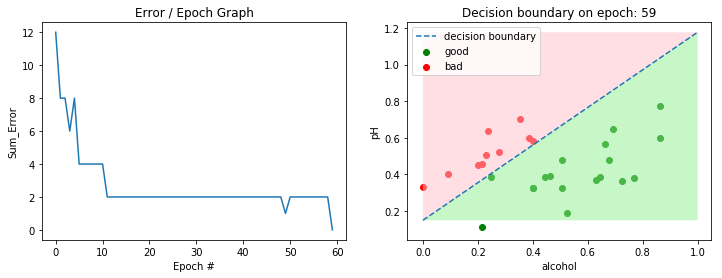

In [28]:
plot_performance(performance, norm_data, 8, 3, -1, save_plot=False)

# V.3 My fair ADALINE

## a) Results after lowering good threshold to 7 and raising bad threshold to 4
       
       * Look at the graph below and see how interlaced both datasets are. There is no way to make a linear classifier that can differentiate between the two without errors
       * Technical term is linearly inseparable problems

In [29]:
norm_train_new_threshold = parse_dataframe(norm_data, good_threshold=7, bad_threshold=4, columns=['pH', 'alcohol', 'good_bad'], set_range=True)
norm_train_new_threshold = dataframe_to_list(norm_train_new_threshold)
print(len(norm_train_new_threshold))

280


In [30]:
performance = train_perceptron(norm_train_new_threshold, l_rate=.1215, n_epoch=250)

>epoch=0, lrate=0.121, error=144.000
>epoch=1, lrate=0.121, error=139.000
>epoch=2, lrate=0.121, error=138.000
>epoch=3, lrate=0.121, error=137.000
>epoch=4, lrate=0.121, error=137.000
>epoch=5, lrate=0.121, error=138.000
>epoch=6, lrate=0.121, error=138.000
>epoch=7, lrate=0.121, error=139.000
>epoch=8, lrate=0.121, error=140.000
>epoch=9, lrate=0.121, error=137.000
>epoch=10, lrate=0.121, error=139.000
>epoch=11, lrate=0.121, error=138.000
>epoch=12, lrate=0.121, error=138.000
>epoch=13, lrate=0.121, error=138.000
>epoch=14, lrate=0.121, error=138.000
>epoch=15, lrate=0.121, error=135.000
>epoch=16, lrate=0.121, error=136.000
>epoch=17, lrate=0.121, error=136.000
>epoch=18, lrate=0.121, error=135.000
>epoch=19, lrate=0.121, error=136.000
>epoch=20, lrate=0.121, error=136.000
>epoch=21, lrate=0.121, error=135.000
>epoch=22, lrate=0.121, error=134.000
>epoch=23, lrate=0.121, error=135.000
>epoch=24, lrate=0.121, error=136.000
>epoch=25, lrate=0.121, error=135.000
>epoch=26, lrate=0.121

>epoch=244, lrate=0.121, error=136.000
>epoch=245, lrate=0.121, error=136.000
>epoch=246, lrate=0.121, error=135.000
>epoch=247, lrate=0.121, error=136.000
>epoch=248, lrate=0.121, error=136.000
>epoch=249, lrate=0.121, error=136.000
[-6.6696357558874535, -68.14447571187995, 86.08855154205447]


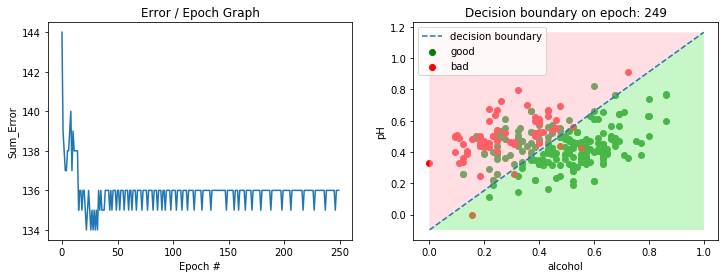

In [31]:
plot_performance(performance, norm_data, good_thresh=7, bad_thresh=4, epoch=-1, save_plot=False)

# b) Implement an ADALINE that:

    • Has randomly initialized weights and bias
    • Uses a linear activation function and some kind of quantizer
    • Uses the Widrow-Hoff learning rule

 Quantizer = converts activation to 1 or 0 based off the value
 
 Widrow-Hoff learning = uses activation value instead of a threshold value for error calculation
 
 
 Stochastic Gradient Descent
    
    Gradient Descent is the process of minimizing error by following the gradients of the cost function.
   
 Similarities between perceptron and adaline model:

    * they are both binary classifiers
    * both have a linear decision boundary
    * both can learn iteratively, sample by sample
    * both use a threshold function
    
 Difference between perceptron and adaline model
    
    * both are class
    * activation functions returns continuous values or floats between 0 and 1 that are more like probablities
    * These continuous values can be used to learn how close or far this prediction was to the correct value
    

In [32]:
def predict_continuous(row, weights):
    activation = weights[0]
    for i in range(len(row)-1):
        #iterate through inputs and multiply them to corresponding weights
        activation += weights[i + 1] * row[i]
    return activation, 1.0 if activation >= 0.0 else -1.0

# c) Create a training function for adaline

    • Take in your red wine data as a parameter
    • Have a way to specify number of training epochs
    • If training epochs is set to 0, your ADALINE should train until it converges
    on a good set of weights.
    • Have a way to specify learning rate.
    • Have an option to perform either online learning or batch learning

In [33]:
# Estimate Perceptron weights using stochastic gradient descent
def train_aladine(train, l_rate, n_epoch, batch=1):

    #random weights
    random.seed(2)
    weights = [random.uniform(0, 1) for i in range(len(train[0]))]
    
    previous_error = 99999
    sum_error = 0
    performance = []
    batch_counter = 0
    error = 0.0
    
    for epoch in range(n_epoch):
        sum_error = 0.0
        for row in train:
            batch_counter += 1
            probability, prediction = predict_continuous(row, weights)
            error += row[-1] - probability
            sum_error += abs(row[-1] - prediction)
#             print(row[-1], prediction, sum_error)
            if (batch_counter == batch):
                batch_counter = 0
                weights[0] = weights[0] + l_rate * error
                for i in range(len(row) - 1):
                    weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
                error = 0
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
        performance.append((epoch, sum_error, weights[1:], weights[0]))
    if n_epoch <= 0:
        epoch = 0
        while (previous_error >= sum_error):
            if (epoch != 0):
                previous_error = sum_error
            sum_error = 0.0
            for row in train:
                batch_counter += 1
                probability, prediction = predict_continuous(row, weights)
                error += row[-1] - probability
                sum_error += abs(row[-1] - prediction)
                if (batch_counter == batch):
                    batch_counter = 0
                    weights[0] = weights[0] + l_rate * error
                    for i in range(len(row) - 1):
                        weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
                error = 0
            print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))            
            performance.append((epoch, sum_error, weights[1:], weights[0]))
            epoch += 1
            
    print(weights)
    return performance

In [34]:
norm_train3 = parse_dataframe(norm_data, good_threshold=7, bad_threshold=4, columns=['pH', 'alcohol', 'good_bad'], set_range=True)
norm_train3 = dataframe_to_list(norm_train3)

In [35]:
performance = train_aladine(norm_train3, l_rate=.006, n_epoch=400, batch=35)

>epoch=0, lrate=0.006, error=126.000
>epoch=1, lrate=0.006, error=126.000
>epoch=2, lrate=0.006, error=126.000
>epoch=3, lrate=0.006, error=126.000
>epoch=4, lrate=0.006, error=126.000
>epoch=5, lrate=0.006, error=126.000
>epoch=6, lrate=0.006, error=126.000
>epoch=7, lrate=0.006, error=126.000
>epoch=8, lrate=0.006, error=126.000
>epoch=9, lrate=0.006, error=126.000
>epoch=10, lrate=0.006, error=126.000
>epoch=11, lrate=0.006, error=126.000
>epoch=12, lrate=0.006, error=126.000
>epoch=13, lrate=0.006, error=126.000
>epoch=14, lrate=0.006, error=126.000
>epoch=15, lrate=0.006, error=126.000
>epoch=16, lrate=0.006, error=126.000
>epoch=17, lrate=0.006, error=126.000
>epoch=18, lrate=0.006, error=126.000
>epoch=19, lrate=0.006, error=126.000
>epoch=20, lrate=0.006, error=126.000
>epoch=21, lrate=0.006, error=126.000
>epoch=22, lrate=0.006, error=126.000
>epoch=23, lrate=0.006, error=126.000
>epoch=24, lrate=0.006, error=126.000
>epoch=25, lrate=0.006, error=126.000
>epoch=26, lrate=0.006

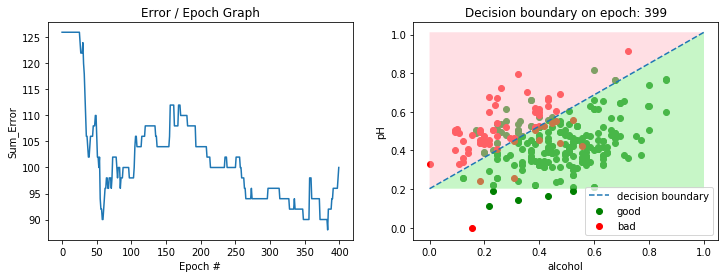

In [36]:
plot_performance(performance, norm_data, good_thresh=7, bad_thresh=4, epoch=-1, save_plot=False)

In [37]:
# bias = performance[-1][3]
# weights = list(performance[-1][2])
# print(bias, weights)

# weights.insert(0, bias)
# print(weights)

# for row in norm_train3:
#     probability, prediction = predict(row, weights)
#     print("Expected=%d, Predicted=%d" % (row[-1], prediction))

# d)
    
    batch size = 1, learning rate = .00212, epoch = 1000
        these hyperparameters actually did very well but didn't give me my best results because the batchsize only allows for one single data points to change the weights ,so the line can't pass into the center of the plots and grab more red and blues despite a few single errors
        
    batch size = 15, learning rate = .00212, epoch = 1000
        this did the best it was a good balance of constant learning rate and a solid batch size that allows the line to move into the mass without too much concern for error over each individual input value.
        
    batch size = 35, learning_rate = 0.006, epoch = 1000
        these settings did okay but the decision line began to get lost within the plot and looks like it couldn't converge on a good set of weights because of how large the batches are. lowest error I got was about 90 with these settings.

# V.4 Advanced wine sampling and resampling

a) Write a function that uses the holdout method to partition the red wine data into a
training and a validation set. The function should take a parameter to adjust the
proportion of training to validation data. It should return a tuple containing:
(training_pandas_dataframe, validation_pandas_dataframe)

In [38]:
# california_housing_dataframe = california_housing_dataframe.reindex(
#     np.random.permutation(california_housing_dataframe.index))

def split_train_validation(data,percent_train_data):
    if (percent_train_data >= 1 or percent_train_data <= 0):
        raise Warning("The percentage must be between 0 and 1")
    train_data = data.iloc[0:round(len(data)*percent_train_data), :]
    validation_data = data.iloc[round(len(data)*percent_train_data):, :]
    return(train_data, validation_data)


train_data, validation_data = split_train_validation(norm_data, percent_train_data=0.8)
print("Total_data {}, training_data {}, validation_data {}".format(len(norm_data), len(train_data), len(validation_data)))

Total_data 1599, training_data 1279, validation_data 320


b) Write a function that generates a k-fold cross validation dataset.

What is k-fold? It is a way of creating training and validation while using your whole data set.
The K stands for the number of groups to split the data set. A proper k-fold cross validation will separate 1 group into validation and the rest into training. 

In [39]:
def k_fold_dataset(data, k, randomize=False):
    if (k == 0):
        raise Warning("the k-fold is 0!")
    groups = []
    previous_row = 0
    training_data = pd.DataFrame()
    return_values = []
    
    if (randomize == True):
        data = data.sample(frac=1).reset_index(drop=True)

    #split into k groups
    for i in range(1, k+1):
        index = round(len(data)/k*i)
        groups.append(data.iloc[previous_row: index,:])
        previous_row = index
    for i in range(len(groups)):
        training_data = pd.DataFrame()
        validation_data = groups[i]
        for x in range(len(groups)):
            if x != i:
                training_data = training_data.append(groups[x])
        return_values.append((training_data, validation_data))
    return (return_values)

In [40]:
norm_train4 = parse_dataframe(norm_data, good_threshold=7, bad_threshold=4, columns=['pH', 'alcohol', 'good_bad'], set_range=True)

In [41]:
a = k_fold_dataset(norm_train4, 10, randomize=True)
count = 0
print(len(norm_train4))
for i,x in a:
    count +=1
    print (i, x)

280
           pH   alcohol  good_bad
28   0.362205  0.569231         1
29   0.244094  0.323077         1
30   0.377953  0.630769         1
31   0.629921  0.794872         1
32   0.417323  0.507692         1
33   0.661417  0.369231         1
34   0.669291  0.246154        -1
35   0.480315  0.507692         1
36   0.425197  0.446154         1
37   0.236220  0.461538         1
38   0.354331  0.246154         1
39   0.763780  0.676923         1
40   0.385827  0.246154         1
41   0.456693  0.538462         1
42   0.480315  0.676923         1
43   0.535433  0.246154         1
44   0.692913  0.476923        -1
45   0.314961  0.415385         1
46   0.472441  0.200000        -1
47   0.417323  0.630769         1
48   0.464567  0.430769         1
49   0.527559  0.538462         1
50   0.456693  0.369231         1
51   0.314961  0.523077         1
52   0.393701  0.369231         1
53   0.559055  0.430769         1
54   0.377953  0.707692         1
55   0.464567  0.676923         1
56   0.763

c) What effects does changing learning rate and number of training epochs have on the
    ADALINE when evaluated via k-fold cross-validation? To address this question,
    you should write (or modify) a function that will train and assess the ADALINE
    on each training and cross-validation fold produced by your k-fold function.

In [42]:
#evaluate model with different k folds
#So i have to train of training_data then I have to run a percent correct on the test data as an evaluation tool
#Write a function that will train on each training and cross validation fold. Basically a for loop that will go through training data
#I should give both the validation and training to the function and compare the losses for each.

In [43]:
# Estimate Perceptron weights using stochastic gradient descent
def train_weights_with_validation(train, validation, l_rate, n_epoch, batch=1):
    performance = []
    batch_counter = 0
    error = 0.0
    #random weights
    random.seed(1)
    weights = [random.uniform(0, 1) for i in range(len(train[0]))]
    
    previous_error = 99999
    sum_train_error = 0
    sum_valid_error = 0
    
    for epoch in range(n_epoch):
        #reset errors for each epoch.
        sum_train_error = 0.0
        sum_valid_error = 0.0

        #Make predictions per row and calculate error to update after each batch
        for row in train:
            batch_counter += 1
            probability, prediction = predict_continuous(row, weights)
            error += row[-1] - probability
            sum_train_error += abs(row[-1] - prediction)
            if (batch_counter == batch):
                batch_counter = 0
                weights[0] = weights[0] + l_rate * error
                for i in range(len(row) - 1):
                    weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
                error = 0
                
        #Make predicitons for validation to do evaluation of model
        for row in validation:
            probability, prediction = predict_continuous(row, weights)
            sum_valid_error += abs(row[-1] - prediction)
        
        #print performance
#         print('>epoch=%d, lrate=%.3f, train_error=%.3f, valid_error=%.3f' % (epoch, l_rate, sum_train_error/len(train), sum_valid_error/len(validation)))
        performance.append((epoch, sum_train_error, sum_valid_error/len(validation), weights[1:], weights[0]))
    if n_epoch <= 0:
        epoch = 0
        while (previous_error >= sum_train_error):
            #Training continues until the error begins to go back up.
            if (epoch != 0):
                previous_error = sum_train_error
                
            #reset errors for each epoch.
            sum_train_error = 0.0
            sum_valid_error = 0.0
            
            #Make predictions per row and calculate error to update after each batch
            for row in train:
                batch_counter += 1
                probability, prediction = predict_continuous(row, weights)
                error += row[-1] - probability
                sum_error += abs(row[-1] - prediction)
                if (batch_counter == batch):
                    batch_counter = 0
                    weights[0] = weights[0] + l_rate * error
                    for i in range(len(row) - 1):
                        weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
                error = 0
            
            #Make predicitons for validation to do evaluation of model
            for row in validation:
                probability, prediction = predict_continuous(row, weights)
                sum_valid_error += abs(row[-1] - prediction)
            
#             print('>epoch=%d, lrate=%.3f, train_error=%.3f, valid_error=%.3f' % (epoch, l_rate, sum_train_error/len(train), sum_valid_error/len(validation)))
            performance.append((epoch, sum_train_error, sum_valid_error/len(validation), weights[1:], weights[0]))
            epoch += 1
            
    return performance

In [44]:
count = 0
sum_valid_error = 0.0

for (train, valid) in a:
    print("{}-Fold Cross Validation".format(count))
    train = dataframe_to_list(train)
    valid = dataframe_to_list(valid)
    performance = train_weights_with_validation(train, valid, l_rate=.5, n_epoch=100, batch=1)
    valid_error = performance[-1][2]
    print("Valid Error : {}".format(valid_error))
    sum_valid_error += valid_error
    count += 1
print(sum_valid_error/count)

0-Fold Cross Validation
Valid Error : 0.2857142857142857
1-Fold Cross Validation
Valid Error : 0.14285714285714285
2-Fold Cross Validation
Valid Error : 0.35714285714285715
3-Fold Cross Validation
Valid Error : 0.42857142857142855
4-Fold Cross Validation
Valid Error : 0.35714285714285715
5-Fold Cross Validation
Valid Error : 0.6428571428571429
6-Fold Cross Validation
Valid Error : 0.42857142857142855
7-Fold Cross Validation
Valid Error : 0.7142857142857143
8-Fold Cross Validation
Valid Error : 0.2857142857142857
9-Fold Cross Validation
Valid Error : 0.21428571428571427
0.38571428571428573


c) observations: 

    * When I changed the learning rate to .02 from .2 the validation error dropped down from .3785 to .3071 which is a huge improvement. If I put the learning rate at .5 the validation error goes up to .42857 because it trains too quickly on the dataset and doesn't fine tune the weights.
    
    * larger epoch number led to larger validation error because of overfitting.


In [45]:
norm_data.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [46]:
norm_train5 = parse_dataframe(norm_data, 7, 4, ['fixed acidity', 'volatile acidity', 'citric acid',
       'chlorides', 'density', 'pH', 'sulphates', 'alcohol', 'good_bad'])
norm_train5 = dataframe_to_list(norm_train5)
performance = train_perceptron(norm_train5, l_rate=.01, n_epoch=100)

>epoch=0, lrate=0.010, error=63.000
>epoch=1, lrate=0.010, error=92.000
>epoch=2, lrate=0.010, error=67.000
>epoch=3, lrate=0.010, error=60.000
>epoch=4, lrate=0.010, error=52.000
>epoch=5, lrate=0.010, error=50.000
>epoch=6, lrate=0.010, error=48.000
>epoch=7, lrate=0.010, error=45.000
>epoch=8, lrate=0.010, error=44.000
>epoch=9, lrate=0.010, error=42.000
>epoch=10, lrate=0.010, error=42.000
>epoch=11, lrate=0.010, error=41.000
>epoch=12, lrate=0.010, error=38.000
>epoch=13, lrate=0.010, error=40.000
>epoch=14, lrate=0.010, error=39.000
>epoch=15, lrate=0.010, error=35.000
>epoch=16, lrate=0.010, error=35.000
>epoch=17, lrate=0.010, error=35.000
>epoch=18, lrate=0.010, error=35.000
>epoch=19, lrate=0.010, error=36.000
>epoch=20, lrate=0.010, error=35.000
>epoch=21, lrate=0.010, error=33.000
>epoch=22, lrate=0.010, error=35.000
>epoch=23, lrate=0.010, error=33.000
>epoch=24, lrate=0.010, error=31.000
>epoch=25, lrate=0.010, error=35.000
>epoch=26, lrate=0.010, error=35.000
>epoch=27, 

In [47]:
norm_train5 = parse_dataframe(norm_data, 7, 4, ['fixed acidity', 'volatile acidity', 'citric acid',
       'chlorides', 'density', 'pH', 'sulphates', 'alcohol', 'good_bad'], set_range=True)
norm_train5 = dataframe_to_list(norm_train5)
performance = train_aladine(norm_train5, l_rate=.05, n_epoch=75, batch=10)

>epoch=0, lrate=0.050, error=164.000
>epoch=1, lrate=0.050, error=136.000
>epoch=2, lrate=0.050, error=130.000
>epoch=3, lrate=0.050, error=120.000
>epoch=4, lrate=0.050, error=110.000
>epoch=5, lrate=0.050, error=108.000
>epoch=6, lrate=0.050, error=106.000
>epoch=7, lrate=0.050, error=102.000
>epoch=8, lrate=0.050, error=98.000
>epoch=9, lrate=0.050, error=94.000
>epoch=10, lrate=0.050, error=94.000
>epoch=11, lrate=0.050, error=86.000
>epoch=12, lrate=0.050, error=84.000
>epoch=13, lrate=0.050, error=82.000
>epoch=14, lrate=0.050, error=82.000
>epoch=15, lrate=0.050, error=80.000
>epoch=16, lrate=0.050, error=80.000
>epoch=17, lrate=0.050, error=74.000
>epoch=18, lrate=0.050, error=72.000
>epoch=19, lrate=0.050, error=70.000
>epoch=20, lrate=0.050, error=70.000
>epoch=21, lrate=0.050, error=68.000
>epoch=22, lrate=0.050, error=66.000
>epoch=23, lrate=0.050, error=64.000
>epoch=24, lrate=0.050, error=62.000
>epoch=25, lrate=0.050, error=62.000
>epoch=26, lrate=0.050, error=62.000
>ep

In [48]:
# bias = performance[-1][3]
# weights = list(performance[-1][2])
# print(bias, weights)

# weights.insert(0, bias)

# for row in norm_train5:
#     prediction = predict(row, weights)
#     print("Expected=%d, Predicted=%d" % (row[-1], prediction))

a) 

    * It trains well on all the data for the perceptron model ,but the aladine is having trouble. With all the data and a learning rate of .01 the model trains decently and get around 28 wrong in a dataset of 280.
    * Aladine doesn't produce as good outputs on the same dataset as the perceptron, but it does train if I put n_epoch at 30 and l_rate at .05 for batch size 10 or less.

b) 

    * For 1 dimensions it is a point on a line
    * For 2 dimensions it is a line on a point
    * For 3 dimensions it is a plane in a 3 dimensional space
    * I can't visually conceptualize beyond 3 dimensions lol. 
      https://www.youtube.com/watch?v=JkxieS-6WuA

# V.6 Marvin’s rebuttal

a) While not a wine. . . find a way to successfully classify the Pan-Galactic Gargle Blaster
dataset. Show that your perceptron or ADALINE successfully classifies the PanGalactic
Gargle Blaster data set by plotting the decision boundary and also show
‘good’ and ‘bad’ Gargle Blaster data points.

In [49]:
gargle_blaster = pd.read_csv("input/Pan Galactic Gargle Blaster.csv")
gargle_blaster

,wonderflonium,fallian marsh gas,quality
0,4.151636,5.350607,2
1,3.403125,4.787343,2
2,5.036224,4.609847,2
3,4.483534,4.332340,9
4,4.215979,5.220295,2
5,4.358374,4.484558,9
6,3.672214,3.440111,1
7,4.940593,3.772474,1
8,4.572444,4.242681,8
9,5.084678,4.044793,2


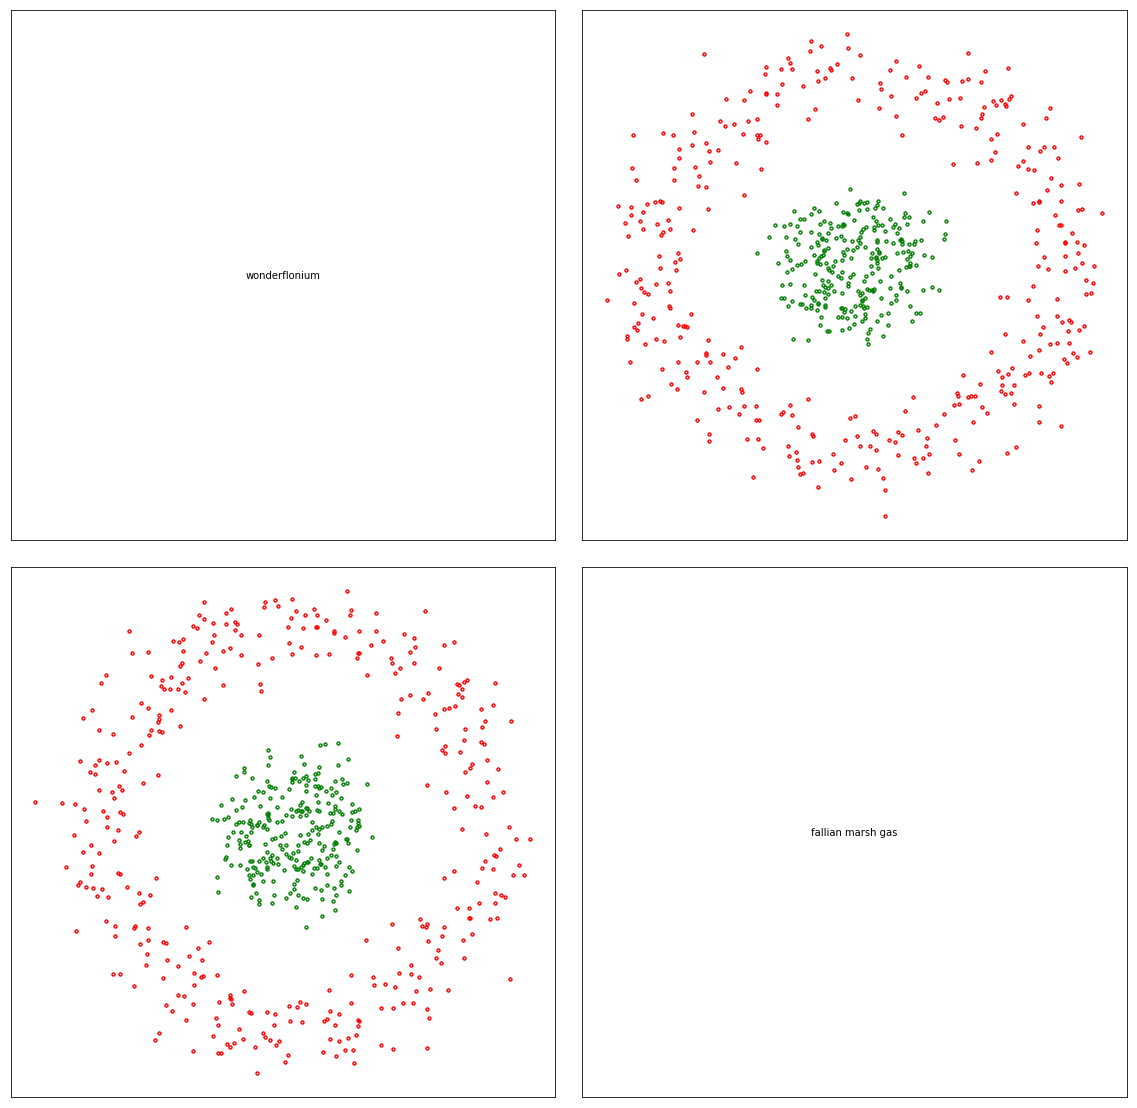

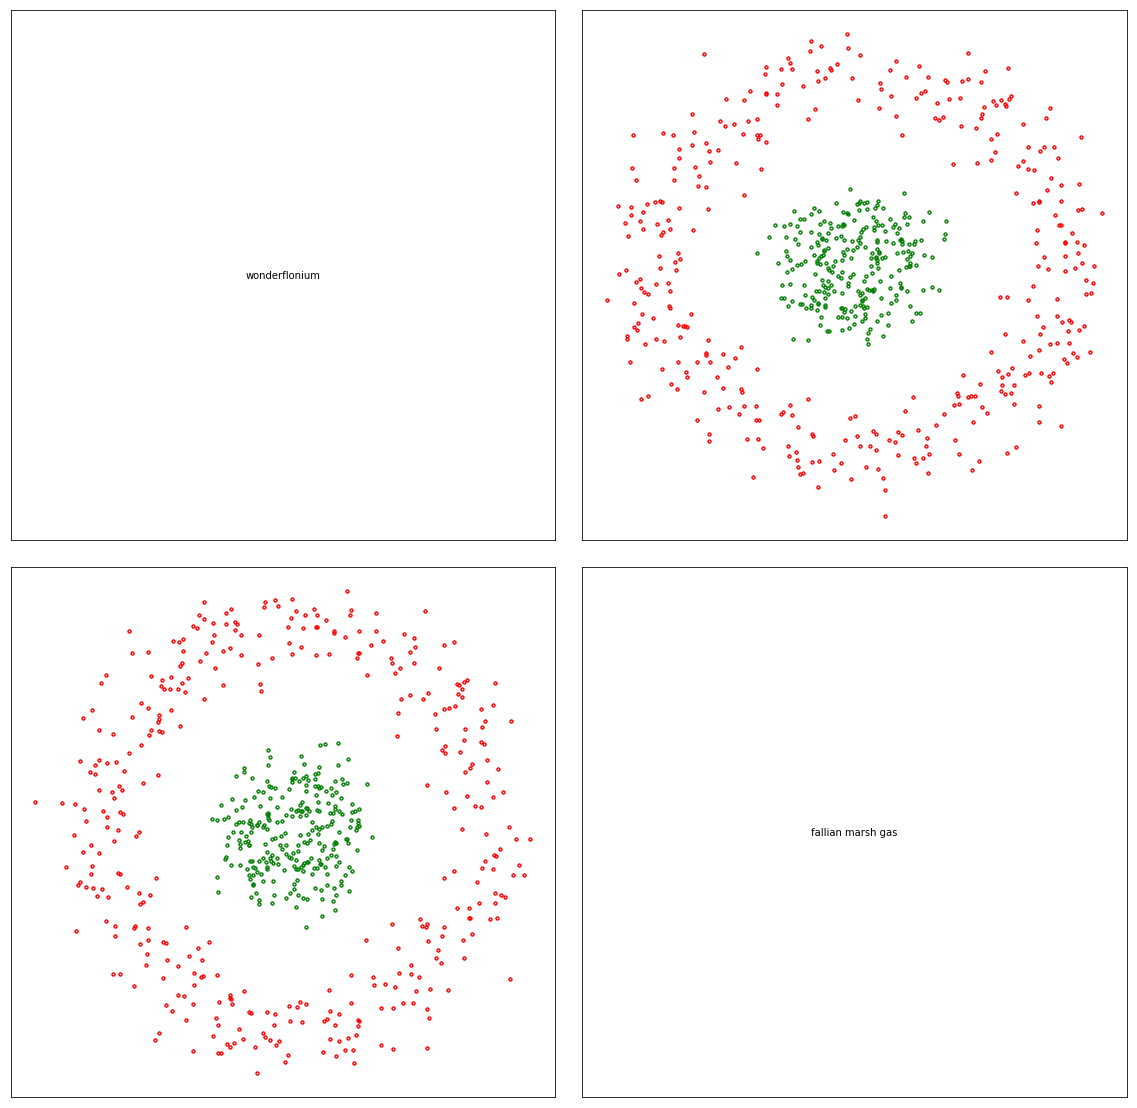

In [50]:
plot_scatter_matrix(gargle_blaster, 8, 3, quality=False)

Normalize the dataset
Put all the data points about the origin (0, 0) and then square everything
This will allow for me to fit a linear equation to divide the data

In [51]:
norm_gargle = gargle_blaster.copy()
features = [x for x in norm_gargle.columns]
for feature in features:
    maxim = max(norm_gargle[feature])
    minim = min(norm_gargle[feature])
    print(feature, maxim, minim)
    if feature != 'quality':
        norm_gargle[feature] = norm_gargle[feature].apply(lambda x: (x - minim) / (maxim - minim))
        norm_gargle[feature] = norm_gargle[feature].apply(lambda x : (x - 0.5)**2)
    
# #Double Check if it was normalized
# norm_gargle.describe()

wonderflonium 5.494471863316591 2.8986665782108765
fallian marsh gas 5.393076313346021 3.0671139720484524
quality 9 1


In [52]:
norm_gargle.describe()

,wonderflonium,fallian marsh gas,quality
count,1.000000e+03,1.000000e+03,1000.00000
mean,4.088237e-02,5.025258e-02,5.06500
std,5.531882e-02,6.629894e-02,2.74815
min,1.264514e-08,1.289517e-08,1.00000
25%,2.473170e-03,2.895876e-03,3.00000
50%,1.110972e-02,1.295805e-02,5.00000
75%,6.566686e-02,8.833224e-02,8.00000
max,2.500000e-01,2.500000e-01,9.00000


In [53]:
def plot_data(gargle_blaster, good_thresh, bad_thresh):
    #Separate Data to good and bad wine depending on threshold
    good_data = gargle_blaster.loc[(gargle_blaster['quality']) >= good_thresh]
    bad_data = gargle_blaster.loc[(gargle_blaster['quality']) <= bad_thresh ]
   
    fig, ax2 = plt.subplots(figsize=(4, 4), ncols=1)


    ax2.plot(good_data.iloc[:, 0], good_data.iloc[:, 1], linestyle='none', marker='.', color='green', mfc='none', label='good')
    ax2.plot(bad_data.iloc[:, 0], bad_data.iloc[:, 1], linestyle='none', marker='.', color='red', mfc='none', label='bad')

    ax2.set_ylabel('wonderflonium')
    ax2.set_xlabel('fallian marsh gas')
    ax2.legend()


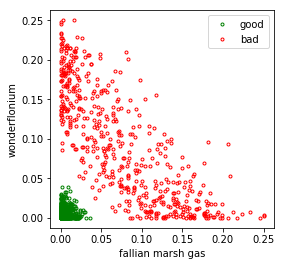

In [54]:
plot_data(norm_gargle, 6, 5)

In [55]:
gargle_train = parse_dataframe(norm_gargle, 6, 5, ['wonderflonium', 'fallian marsh gas','good_bad'])
gargle_train = dataframe_to_list(gargle_train)
gargle_train


[[0.0002996292447283289, 0.23207476115210623, 0.0],
 [0.0934303721413847, 0.05739735385414649, 0.0],
 [0.10463014767932766, 0.02665600682588135, 0.0],
 [0.012221139943851178, 0.0019323130649065926, 1.0],
 [5.5908999959345606e-05, 0.1812341978012114, 0.0],
 [0.0038854268986453695, 0.01196862236248558, 1.0],
 [0.04080434840002031, 0.1153536486053308, 0.0],
 [0.08215419032612466, 0.03870854523798064, 0.0],
 [0.020967262831443487, 2.9277352379536033e-05, 1.0],
 [0.11705447910010275, 0.006346778368424934, 0.0],
 [0.07140851464475222, 0.10450009573548869, 0.0],
 [0.11406766566832637, 0.021311289702935377, 0.0],
 [0.0642550716258961, 0.052334848853142865, 0.0],
 [0.008582372522392844, 0.13835332848617665, 0.0],
 [0.02081251578243714, 0.15527059514372799, 0.0],
 [0.011650515570308067, 0.11456186335696493, 0.0],
 [0.009059017486790609, 0.005046559641609717, 1.0],
 [0.03275565307668291, 0.10071191723636598, 0.0],
 [0.15079778052566847, 0.007422394550558622, 0.0],
 [0.04812404280660423, 0.2073540

In [56]:
performance = train_perceptron(gargle_train, l_rate=.505, n_epoch=25)

>epoch=0, lrate=0.505, error=142.000
>epoch=1, lrate=0.505, error=18.000
>epoch=2, lrate=0.505, error=10.000
>epoch=3, lrate=0.505, error=6.000
>epoch=4, lrate=0.505, error=4.000
>epoch=5, lrate=0.505, error=2.000
>epoch=6, lrate=0.505, error=2.000
>epoch=7, lrate=0.505, error=2.000
>epoch=8, lrate=0.505, error=2.000
>epoch=9, lrate=0.505, error=2.000
>epoch=10, lrate=0.505, error=2.000
>epoch=11, lrate=0.505, error=2.000
>epoch=12, lrate=0.505, error=2.000
>epoch=13, lrate=0.505, error=2.000
>epoch=14, lrate=0.505, error=2.000
>epoch=15, lrate=0.505, error=2.000
>epoch=16, lrate=0.505, error=2.000
>epoch=17, lrate=0.505, error=0.000
>epoch=18, lrate=0.505, error=0.000
>epoch=19, lrate=0.505, error=0.000
>epoch=20, lrate=0.505, error=0.000
>epoch=21, lrate=0.505, error=0.000
>epoch=22, lrate=0.505, error=0.000
>epoch=23, lrate=0.505, error=0.000
>epoch=24, lrate=0.505, error=0.000
[0.13436424411240122, -2.0605287180069776, -1.9004931796305273]


In [57]:
def graph_gargle(formula, gargle, ax2):     
    x = gargle['fallian marsh gas'].tolist()
    x = [i for i in frange(min(x), max(x), .1)]
    y = eval_y_per_x(formula, x)
    d_min = [min(y) for l in range(0, len(x))]
    d_max = max(y)
    ax2.plot(x, y, linestyle='dashed', label='decision boundary')
    ax2.fill_between(x, y, d_min, facecolor='lightgreen', alpha=0.5)
    ax2.fill_between(x, y, d_max, facecolor='pink', alpha=0.5)

In [58]:
#if epoch is equal to -1 then it shows the line for last epoch
#please put a valid epoch under the number of epoch's attempted
import math 

def plot_gargle(performance, gargle_blaster, good_thresh, bad_thresh, epoch, save_plot=False):
    #Separate Data to good and bad wine depending on threshold
    good_data = gargle_blaster.loc[(gargle_blaster['quality']) >= good_thresh]
    bad_data = gargle_blaster.loc[(gargle_blaster['quality']) <= bad_thresh ]
   
    listofepochs = [x[0] for x in performance]
    error = [x[1] for x in performance]
    
    #find length of epoch's so I can use last one if -1
    if (epoch >= len(listofepochs)):
        print("Please Put Valid Epoch. If you wish for last epoch put -1")
        return
    
    if (epoch < 0):
        epoch = len(listofepochs) - 1
        
    fig, (ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=2)
    ax1.plot(listofepochs, error)
    ax1.set_title('Error / Epoch Graph')
    ax1.set_ylabel('Sum_Error')
    ax1.set_xlabel('Epoch #')

    ax2.plot(good_data.iloc[:, 0], good_data.iloc[:, 1], linestyle='none', marker='.', color='green', mfc='none', label='good')
    ax2.plot(bad_data.iloc[:, 0], bad_data.iloc[:, 1], linestyle='none', marker='.', color='red', mfc='none', label='bad')
    
    formula = '({}*x + {})/-{}'.format(performance[epoch][2][1], performance[epoch][3], performance[epoch][2][0])

    graph_gargle(formula, gargle_blaster, ax2)
    ax2.set_title('Decision boundary on epoch: {}'.format(epoch))
    ax2.set_ylabel('wonderflonium')
    ax2.set_xlabel('fallian marsh gas')
    ax2.legend()
    if (save_plot == True):
        plt.savefig('gargle_graph.png')

In [59]:
gargle_blaster.head()

,wonderflonium,fallian marsh gas,quality
0,4.151636,5.350607,2
1,3.403125,4.787343,2
2,5.036224,4.609847,2
3,4.483534,4.332340,9
4,4.215979,5.220295,2


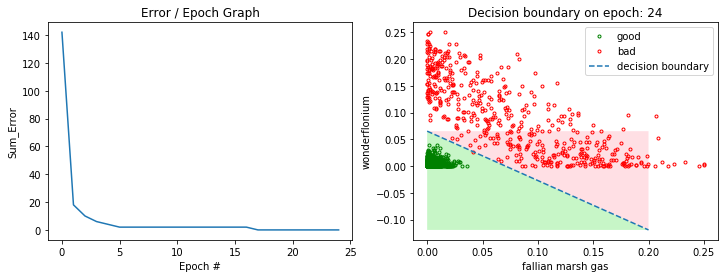

In [60]:
plot_gargle(performance, norm_gargle, good_thresh=6, bad_thresh=5, epoch=-1, save_plot=False)